# ***Assignment 1.2 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

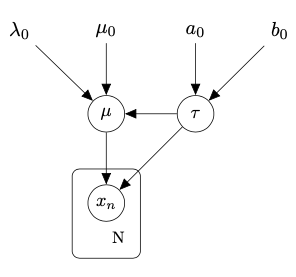

### ***Question 1.2.7:***

Implement a function that generates data points for the given model.

In [83]:
import numpy as np
def generate_data(mu, tau, N):
  np.random.seed(0)
  D = np.random.normal(mu, 1/np.sqrt(tau), N)
  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



In [84]:
import matplotlib.pyplot as plt
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
# Insert your code here

plt.hist(dataset_1, bins=30, alpha=0.5, label='N=10')
plt.savefig('Report/figures/1.2/dataset_1.png')
plt.clf()
plt.hist(dataset_2, bins=30, alpha=0.5, label='N=100')
plt.savefig('Report/figures/1.2/dataset_2.png')
plt.clf()
plt.hist(dataset_3, bins=30, alpha=0.5, label='N=1000')
plt.savefig('Report/figures/1.2/dataset_3.png')
plt.clf()


<Figure size 640x480 with 0 Axes>

### ***Question 1.2.8:***

Find ML estimates of the variables μ and τ

In [85]:
from scipy import stats
def ML_est(data):
  return np.mean(data), 1/np.var(data)

In [86]:
print(ML_est(dataset_1))
print(ML_est(dataset_2))
print(ML_est(dataset_3))


(2.043722377390312, 0.5346208711845316)
(1.0845813067074894, 0.49220998007161765)
(0.9359973504790137, 0.513223482048345)


### ***Question 1.2.9:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  # your implementation

  return exact_post_dist_parameters

In [87]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
    """
    Compute the exact posterior parameters for the Normal-Gamma distribution.

    Parameters:
    - D: array-like, the observed data points.
    - a_0, b_0: prior shape and rate parameters for the Gamma distribution of tau.
    - mu_0, lambda_0: prior mean and precision parameters for the Normal distribution of mu given tau.

    Returns:
    - a_N, b_N: posterior shape and rate parameters for tau.
    - mu_N, lambda_N: posterior mean and precision parameters for mu given tau.
    """
    N = len(D)
    x_bar = np.mean(D)
    sum_squared_diffs = np.sum((D - x_bar) ** 2)

    lambda_N = lambda_0 + N
    mu_N = (lambda_0 * mu_0 + N * x_bar) / lambda_N
    a_N = a_0 + N / 2
    b_N = b_0 + 0.5 * sum_squared_diffs + (lambda_0 * N * (x_bar - mu_0) ** 2) / (2 * lambda_N)

    return a_N, b_N, mu_N, lambda_N




### ***Question 1.2.10:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [92]:
# prior parameters
mu_0 = 0
lambda_0 = 0.1
a_0 = 10
b_0 = 1

Continue with a helper function that computes ELBO:


In [93]:
from scipy.special import digamma, gammaln
import numpy as np
def compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N):
    """
    Compute the Evidence Lower Bound (ELBO) given prior and posterior parameters.

    Parameters:
    - D: array-like, the observed data points.
    - Prior parameters: a_0, b_0, mu_0, lambda_0.
    - Posterior parameters: a_N, b_N, mu_N, lambda_N.

    Returns:
    - elbo: The computed ELBO value.
    """
    N = len(D)
    x_bar = np.mean(D)
    sum_squared_diffs = np.sum((D - x_bar) ** 2)

    # Expected values under q
    E_tau = a_N / b_N
    E_log_tau = digamma(a_N) - np.log(b_N)

    # Compute each term in the ELBO
    # 1. E_q[ln p(D | mu, tau)]
    term1 = 0.5 * N * (E_log_tau - np.log(2 * np.pi)) - 0.5 * E_tau * (
        sum_squared_diffs + N * (x_bar - mu_N) ** 2 + (1 / lambda_N)
    )

    # 2. E_q[ln p(mu | tau)]
    term2 = 0.5 * (E_log_tau - np.log(2 * np.pi / lambda_0)) - 0.5 * E_tau * (
        lambda_0 * (mu_N - mu_0) ** 2 + (1 / lambda_N)
    )

    # 3. E_q[ln p(tau)]
    term3 = a_0 * np.log(b_0) - gammaln(a_0) + (a_0 - 1) * E_log_tau - b_0 * E_tau

    # 4. Entropy of q(mu)
    entropy_q_mu = 0.5 * np.log(2 * np.pi * np.e / (lambda_N * E_tau))

    # 5. Entropy of q(tau)
    entropy_q_tau = a_N - np.log(b_N) + gammaln(a_N) + (1 - a_N) * digamma(a_N)

    # Total ELBO
    elbo = term1 + term2 + term3 + entropy_q_mu + entropy_q_tau

    return elbo



Now, implement the CAVI algorithm:

In [94]:
from scipy.special import digamma, gammaln
import numpy as np


def CAVI(D, a_0, b_0, mu_0, lambda_0, max_iter=100, tol=1e-6):
    """
    Perform Coordinate Ascent Variational Inference (CAVI) for the Normal-Gamma model.

    Parameters:
    - D: array-like, the observed data points.
    - Prior parameters: a_0, b_0, mu_0, lambda_0.
    - max_iter: Maximum number of iterations.
    - tol: Tolerance for convergence based on ELBO change.

    Returns:
    - a_N, b_N: Variational parameters for tau.
    - mu_N, lambda_N: Variational parameters for mu.
    - elbos: List of ELBO values at each iteration.
    """
    N = len(D)
    x_bar = np.mean(D)
    sum_squared_diffs = np.sum((D - x_bar) ** 2)

    # Initial guess for E[tau]
    E_tau = a_0 / b_0

    # Initialize variational parameters
    mu_N = mu_0
    lambda_N = lambda_0
    a_N = a_0
    b_N = b_0

    elbos = []
    prev_elbo = -np.inf

    for iteration in range(max_iter):
        # Update q(mu): Variational parameters for mu
        lambda_N = lambda_0 + N * E_tau
        mu_N = (lambda_0 * mu_0 + N * E_tau * x_bar) / lambda_N

        # Update q(tau): Variational parameters for tau
        a_N = a_0 + (N + 1) / 2
        b_N = b_0 + 0.5 * (
            sum_squared_diffs + N * (x_bar - mu_N) ** 2 + (1 / lambda_N) + lambda_0 * (mu_N - mu_0) ** 2
        )

        # Compute expectations
        E_tau = a_N / b_N
        E_log_tau = digamma(a_N) - np.log(b_N)

        # Compute ELBO
        elbo = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N)
        elbos.append(elbo)

        # Check for convergence
        if np.abs(elbo - prev_elbo) < tol:
            print(f"Converged at iteration {iteration + 1}")
            break
        prev_elbo = elbo

    return a_N, b_N, mu_N, lambda_N, elbos


Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


Converged at iteration 5
[-202.14841229353758, -200.74295865858105, -200.7429207769657, -200.74292077379468, -200.74292077379442]
5


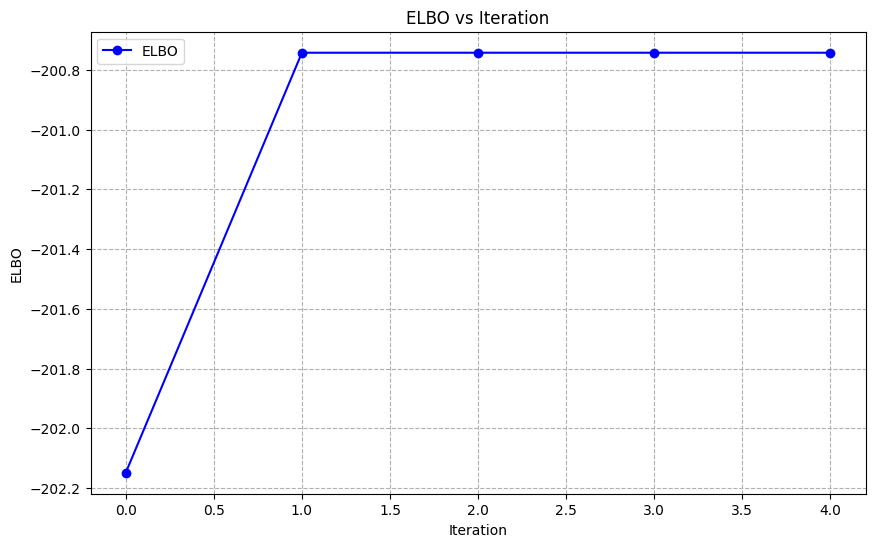

(60.0, 102.6414189949626, 1.083497808898591, 100.1)
1.0827442223433874 59.03818724392864 60.5 102.64991651271433


<Figure size 640x480 with 0 Axes>

In [95]:
# Insert your main code here


# Example flow for dataset_2:
  ##  mu_ml, tau_ml = ML_est(dataset_2)
  ##  a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  plot elbos, show convergence
  ##  exact_post_dist_param = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot

mu_ml, tau_ml = ML_est(dataset_3)
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0, max_iter=1000, tol=1e-10)
print(elbos)
print(iter)

plt.figure(figsize=(10, 6))
plt.plot(range(iter), elbos, label='ELBO', color='blue', marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.title('ELBO vs Iteration')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()
plt.savefig('Report/figures/1.2/elbos.png')
plt.clf()

exact_post_dist_param = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
print(exact_post_dist_param)
print(mu_N, lambda_N, a_N, b_N)


